In [6]:
import chainer
from chainer import configuration
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
from chainer import optimizers, initializers, serializers

import math
import numpy as np
#import cupy as cp
import random
import os
import cupy as cp
import sklearn
from sklearn.utils import shuffle
import pickle
import pandas as pd
import seaborn as sns

import import_ipynb
import dnn_models
from dnn_models import MLP1L, MLP2L, MLP3L, MLP4L

import DNN_model_final
from DNN_model_final import CustomMLP

import final_pole_module
from final_pole_module import detect_cusp, unif_pole, T1, T2, Einput
from final_pole_module import mu1, mu2, T1, T2, T4, Nreal, Nimag, hbarc
from final_pole_module import Einput, Ereal, Eimag, Erealfar, Eimagfar, E_exp, labelz, inspect, NEpoints
from final_pole_module import skip_duplicate, export_data, import_data, get_traintest, directory

import matplotlib.pyplot as plt
import time

importing Jupyter notebook from dnn_models.ipynb
importing Jupyter notebook from DNN_model_final.ipynb
importing Jupyter notebook from final_pole_module.ipynb
Number of poles to be generated per class: 9000000
Ndata to be generated= 36000000
Your directory is: curriculum02_training


In [7]:
directory1 = 'SMORMS_7diamond1_retest_3currs1000each_curr03_full' #full'
curriculum = 3
batchsize = 64

training_accu1 = pickle.load(open(os.path.join(directory1,"training_accu1.pkl"),"rb"))
testing_accu1 = pickle.load(open(os.path.join(directory1,"testing_accu1.pkl"),"rb"))
training_loss1 = pickle.load(open(os.path.join(directory1,"training_loss1.pkl"),"rb"))
testing_loss1 = pickle.load(open(os.path.join(directory1,"testing_loss1.pkl"),"rb"))
print('curriculum: {:02d}'.format(curriculum), '       batchsize: {:04d}'.format(batchsize))
print('recent epoch:', len(training_accu1))
 
print('baseline random model:{: .06f}'.format(1/(curriculum+2)))
print('MPL1 train_accu:{: .06f}'.format(float(training_accu1[len(training_accu1)-1])), '  MPL1 test_accu:{: .06f}'.format(float(testing_accu1[len(testing_accu1)-1])))

drop = float(training_accu1[len(training_accu1)-1]) - float(training_accu1[len(training_accu1)-2])
if drop<0:
    print('accuracy decrease by:{: .06f}'.format(drop))
elif drop>0:
    print('accuracy increase by:{: .06f}'.format(drop))
elif drop == 0:
    print('no change')
print()
#print('MPL1 train_loss:{: .06f}'.format(float(training_loss1[len(training_loss1)-1])), '  MPL1 test_loss:{: .06f}'.for

curriculum: 03        batchsize: 0064
recent epoch: 3000
baseline random model: 0.200000
MPL1 train_accu: 0.898958   MPL1 test_accu: 0.828333
accuracy decrease by:-0.001198



In [8]:
exec('training_accu1=pickle.load(open(os.path.join(directory1,"training_accu1.pkl"),"rb"))')
exec('testing_accu1=pickle.load(open(os.path.join(directory1,"testing_accu1.pkl"),"rb"))')
exec('training_loss1=pickle.load(open(os.path.join(directory1,"training_loss1.pkl"),"rb"))')
exec('testing_loss1=pickle.load(open(os.path.join(directory1,"testing_loss1.pkl"),"rb"))') 
print('last epoch:', len(training_accu1))

last epoch: 3000


In [9]:
#Convert to CuPy arrays and then to NumPy arrays
training_accu1 = cp.array(training_accu1).get()
testing_accu1 = cp.array(testing_accu1).get()

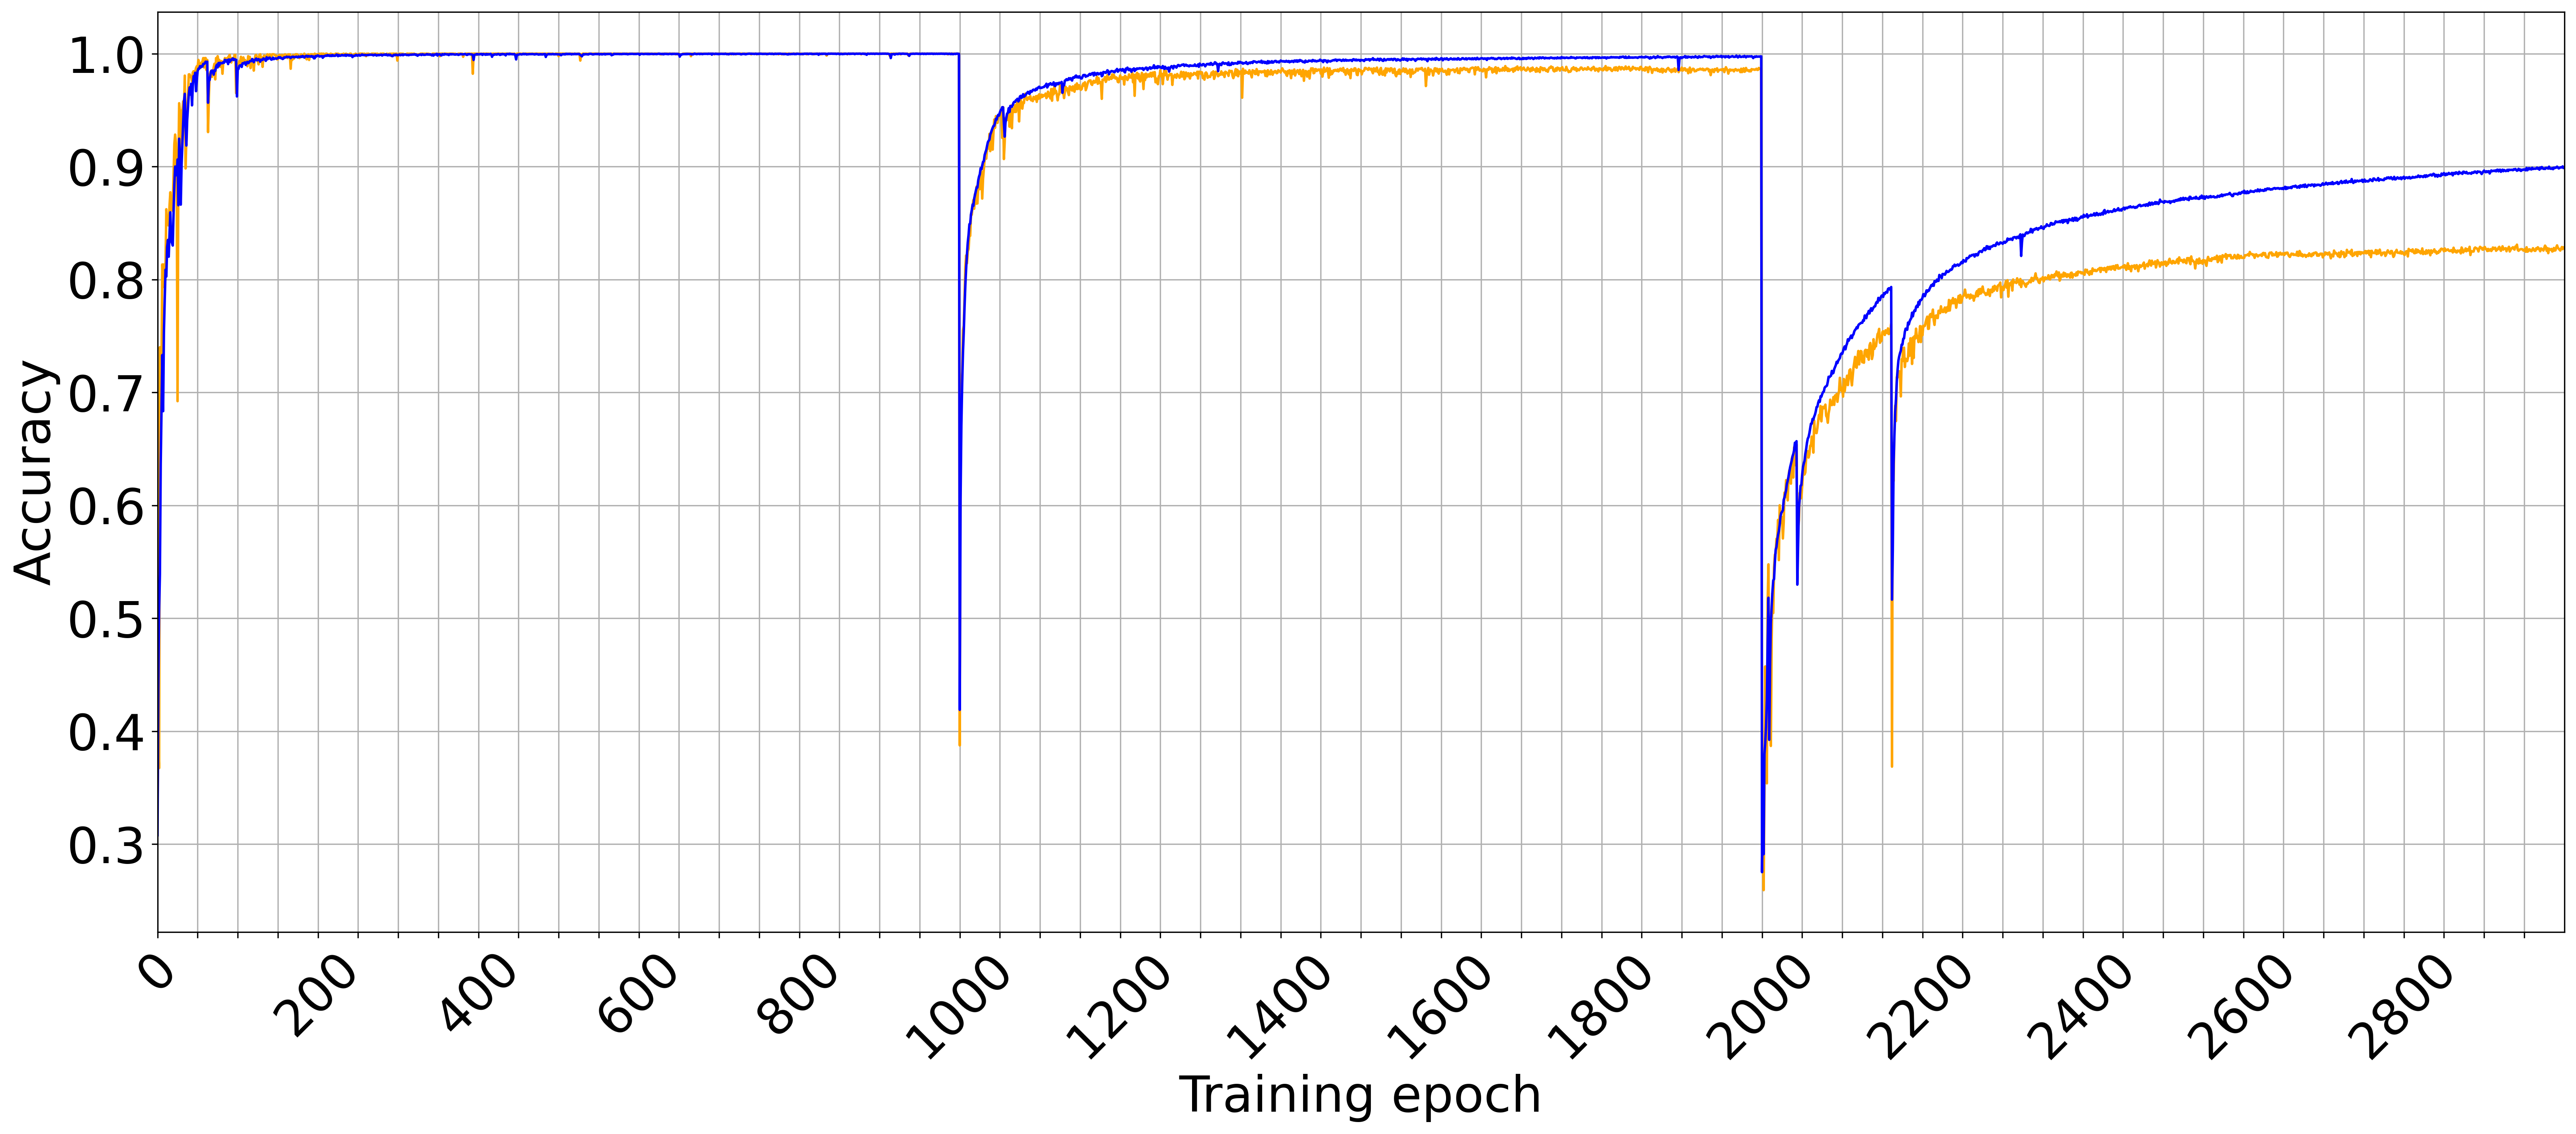

In [10]:
fig = plt.figure(figsize=(26, 10), dpi=300)
test = plt.plot(testing_accu1,'orange')
train = plt.plot(training_accu1,'blue')
#plt.title('Adam: [400-400-400], 72.50%, 73.92%',fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

# Set x-axis ticks at intervals of 100
tick_positions = range(0, len(testing_accu1), 50)
plt.xticks(tick_positions, fontsize=30)

# Set x-axis tick labels at intervals of 200
tick_labels = [str(i) if i % 200 == 0 else '' for i in tick_positions]
plt.xticks(tick_positions, tick_labels, fontsize=30, rotation = 45)

# Set x-axis limits to ensure 0 is not offset
plt.xlim(0, len(testing_accu1))
plt.xlabel('Training epoch', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)


plt.grid(True)

fig.savefig('SMORMS_7diamond1_retest3currs1000each.png',bbox_inches='tight')

In [11]:
gpu_id = 0
device = chainer.get_device(gpu_id)

In [12]:
dnntest1 = CustomMLP(7,[300,400,500,300,200,100,20]) #200-100 SMORMS3
dnntest1 = L.Classifier(dnntest1)

dnntest1.to_device(device)
device.use()

directory = 'SMORMS_7diamond1_retest_3currs1000each_curr03_snapshot\epoch003000'  #'REORG_RAW_ASCDESCAdam3_2_curr32_snapshot\epoch000300'
serializers.load_npz(os.path.join(directory,'MLP3.model'), dnntest1)
dnntest1 = dnntest1.predictor 

In [13]:
dataset_dir = 'curriculum03_validation'
  #35 #32:35, 31: 34, 32:33
labels = []

oldcurr = [0, 1, 2,
           3, 4,
              5, 6, 7]

num_labels = len(oldcurr)

selected_indices = oldcurr[:num_labels]

for index in selected_indices:
    label_filename = f'ModEsq{index:02d}.pkl'
    label_path = os.path.join(dataset_dir, label_filename)
    
    # Load and convert label to cp.asarray
    label_data = cp.asarray(pickle.load(open(label_path, "rb")), dtype=np.float32)
    
    # Assign the label to a variable with a dynamic name (e.g., Label00, Label01, ...)
    globals()[f'Label{index:02d}'] = label_data
    
    # Append the label to the list
    labels.append(label_data)

In [14]:
label_arrays = []

selected_indices = oldcurr[:num_labels]

for index in selected_indices:
    label_filename = f'labelin{index:02d}.pkl'
    label_path = os.path.join(dataset_dir, label_filename)
    
    # Load and convert label to cp.asarray
    label_data = cp.asarray(pickle.load(open(label_path, "rb")), dtype=np.float32)
    
    # Assign the label to a variable with a dynamic name (e.g., Label00, Label01, ...)
    globals()[f'Label{index:02d}'] = label_data
    
    label_array = []
    for n in range(len(label_data)):
        label = dnntest1(label_data)[n].array.argmax()
        label_array.append(label.tolist())
    
    label_arrays.append(label_array)

In [15]:
# table_data = np.zeros((num_labels, num_labels), dtype=int)

# for i in range(num_labels):
#     for j in range(num_labels):
#         table_data[i, j] = sum(1 for x in label_arrays[j] if x == selected_indices[i])

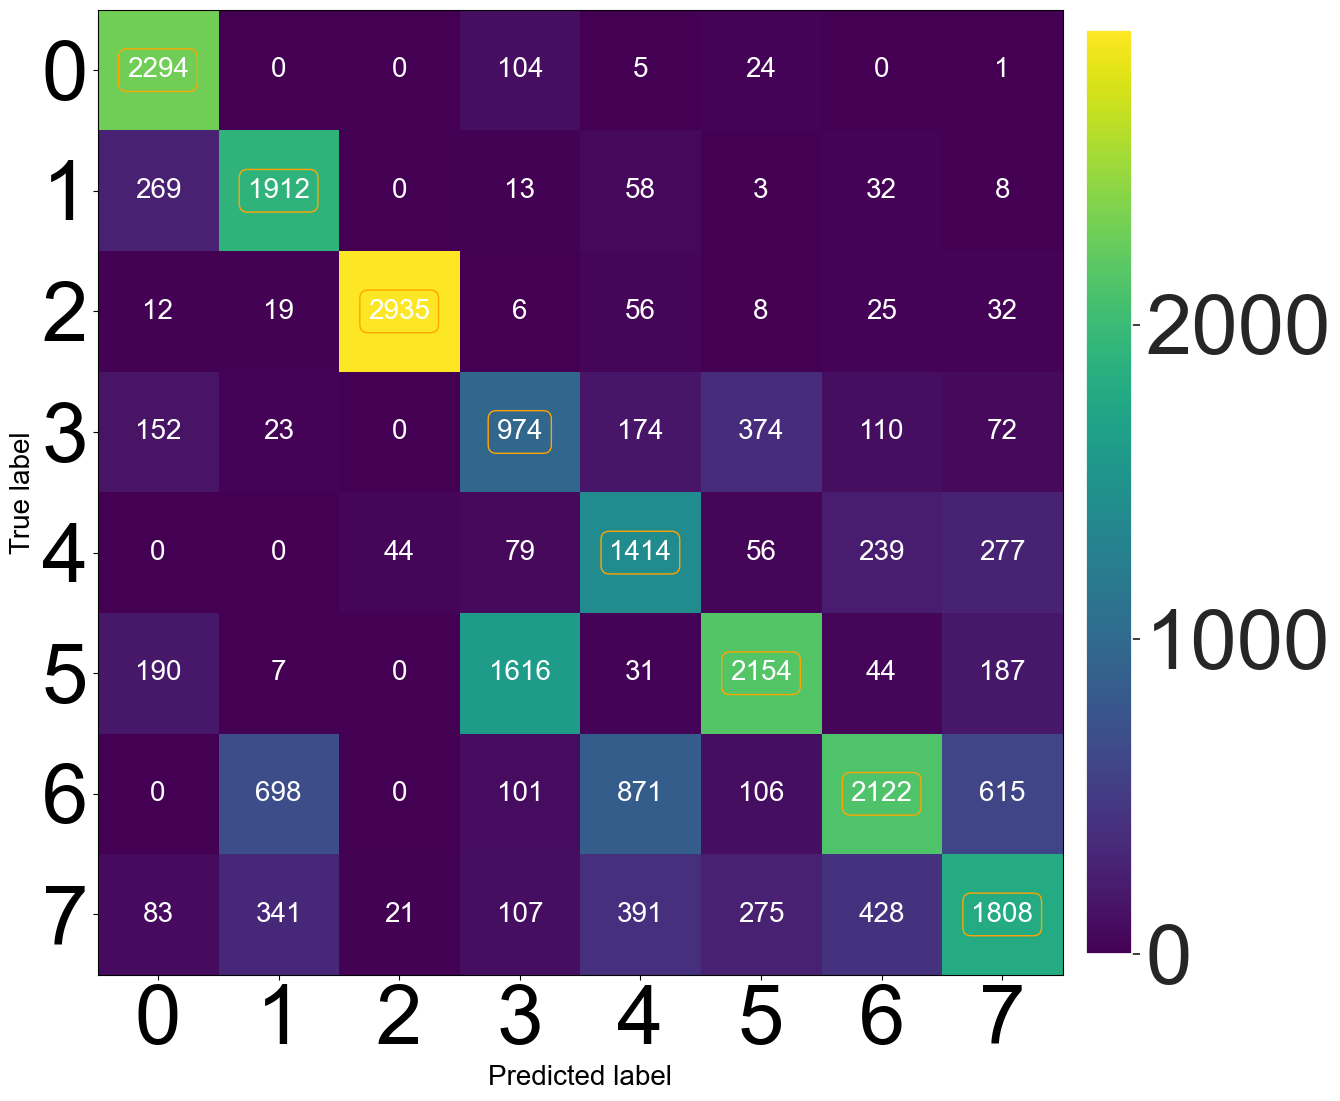

In [26]:
table_data = np.zeros((num_labels, num_labels), dtype=int)

for i in range(num_labels):
    for j in range(num_labels):
        table_data[i, j] = sum(1 for x in label_arrays[j] if x == selected_indices[i])

table_data = np.transpose(table_data)

table_row = [str(i) for i in selected_indices]
table_col = [str(i) for i in selected_indices]

# table_data = np.zeros((num_labels, num_labels), dtype=int)

for i in range(num_labels):
    for j in range(num_labels):
        table_data[i, j] = label_arrays[j].count(i)

# table_data = np.transpose(table_data)
        
#table_row = [f'Class{i:02d}' for i in selected_indices]
#table_col = [str(i) for i in selected_indices]  


# Increase figure size
fig, ax = plt.subplots(figsize=(15, 15))

# Use Seaborn for a better style
sns.set()

# Adjust aspect ratio
ax.set_aspect('equal', adjustable='box')

# Plot the heatmap
im = ax.imshow(table_data, cmap='viridis')

# Set labels and ticks
ax.set_xticks(np.arange(len(table_col)))
ax.set_xticklabels(table_col, rotation=0, fontsize=60)
ax.set_yticks(np.arange(len(table_row)))
ax.set_yticklabels(table_row, fontsize=60)

# Set title
#ax.set_title('Confusion Matrix', fontweight="bold", fontsize=20, pad=20)

#Set axis labels
ax.set_ylabel('True label', fontsize=20)
ax.set_xlabel('Predicted label', fontsize=20)

#Highlight the edges of the diagonal cells
for i in range(len(table_row)):
    for j in range(len(table_col)):
        text = ax.text(j, i, table_data[i, j],
                       ha="center", va="center", color="w", fontsize=20)
        # Draw borders around the diagonal cells
        if i == j:
            text.set_bbox(dict(facecolor='none', edgecolor='orange', boxstyle='round,pad=0.3'))

# Display colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.ax.tick_params(labelsize=60)

plt.show()
fig.savefig('SMORMS_7diamond1_retest_3currs1000each_matrix.png', bbox_inches='tight')

In [13]:
# # Sum of each row
# row_sums = np.sum(table_data, axis=1)
# print("Row sums:", row_sums)

# # Sum of each column
# column_sums = np.sum(table_data, axis=0)
# print("Column sums:", column_sums)

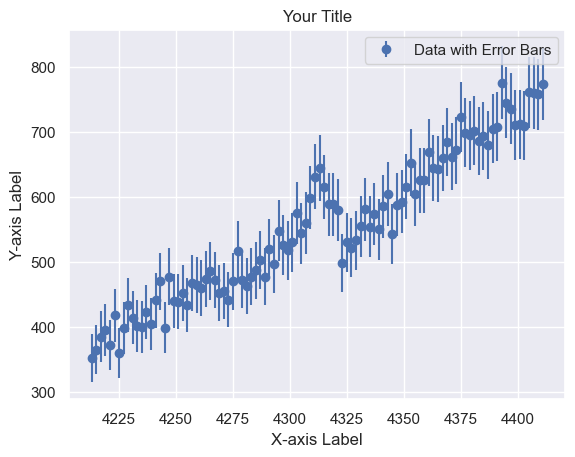

In [14]:
# Load the DataFrame from CSV
file_path = 'hepdataLHCB.csv'
df = pd.read_csv(file_path)
df = df.loc[(df.MEV >= 4212) & (df.MEV <= 4412)].copy()

# Assuming 'x_column', 'y_column', 'upper_bound_column', 'lower_bound_column' are the column names
x_values = df['MEV']
y_values = df['DN_DM']
upper_bound_values = df['STATPLUS']
lower_bound_values = df['STATMINUS']

# Calculate the error as the difference between upper and lower bounds
error_values = [upper - lower for upper, lower in zip(upper_bound_values, lower_bound_values)]

# Plotting with error bars
plt.errorbar(x_values, y_values, yerr=error_values, fmt='o', label='Data with Error Bars')

# Customize the plot
plt.title('Your Title')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()

# Display the plot
plt.show()

In [15]:
# len(df)

In [16]:
# print(df)

In [17]:
def gen_Eaxis(df):
    x_data = []

    for index, row in df.iterrows():
        x_val = random.gauss(mu=row['MEV'],sigma=5.0) #random.uniform(row['MEV_LOW'], row['MEV_HIGH'])
        x_data.append(x_val)

    return np.array(x_data)

def gen_Amp(df):
    y_data = []

    for index, row in df.iterrows():
        y_val = random.gauss(mu=row['DN_DM'], sigma=5.0)
        y_data.append(y_val)

    return np.array(y_data)


# def gen_Amp(df):
#     y_data = []

#     for i in range(len(df)):
#         y_val = random.uniform(df['DN_DM'].iloc[i] + df['STATMINUS'].iloc[i], df['DN_DM'].iloc[i] + df['STATPLUS'].iloc[i])
#         y_data.append(y_val)

#     return np.array(y_data)

def gen_Exp(df):
    x_data = gen_Eaxis(df)
    y_data = gen_Amp(df)

    return np.concatenate((x_data, y_data), axis=0)

In [18]:
Exp_data = []
for i in range(3000):
    Exp = gen_Exp(df)
    Exp_data.append(Exp)

In [19]:
Exp_data = cp.asarray(Exp_data, dtype=np.float32)

Exp_labels = []
for n in range(len(Exp_data)):
    label = dnntest1(Exp_data)[n].array.argmax()
    Exp_labels.append(label.tolist())

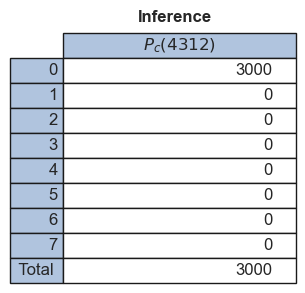

In [20]:
# Define the range for Exp_labels.count
label_range = range(8)  # Adjust this range based on your needs

# Generate table_data, table_col, and table_row dynamically
table_data = [[Exp_labels.count(label)] for label in label_range] + [[len(Exp_labels)]]
table_col = ['$P_c(4312)$']
table_row = [str(label) for label in label_range] + [' Total ']

# Create and display the table
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_axis_off() 
table = ax.table(cellText=table_data, rowLabels=table_row, colLabels=table_col, rowLoc='right', loc='upper left',
                rowColours=['lightsteelblue'] * (len(label_range) + 1) + ['silver'], colColours=['lightsteelblue'])

ax.set_title('Inference', fontweight='bold') 
table.scale(1, 1.5)

plt.show()
fig.savefig('GAUSS_SIGMA_5_900epoch_Inference_300_300_300_SMORMS_conf_THESIS.png', bbox_inches='tight')

In [21]:
dataset = pd.read_csv('hepdataLHCB.csv')

# Define the range
lower_bound = 4260
upper_bound = 4359

# Find the rows that meet the condition
filtered_rows = dataset[(dataset['MEV'] > lower_bound) & (dataset['MEV'] < upper_bound)]

# Display the row numbers
row_numbers = filtered_rows.index + 1  # Adding 1 to start counting from 1 instead of 0
print("Row numbers for elements in the specified range:", row_numbers)

Row numbers for elements in the specified range: Int64Index([114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
            127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
            140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
            153, 154, 155, 156, 157, 158, 159, 160, 161, 162],
           dtype='int64')


In [22]:
len(row_numbers)

49

In [23]:
# Sum of each row
row_sums = np.sum(table_data, axis=1)
print("Row sums:", row_sums)

# Sum of each column
column_sums = np.sum(table_data, axis=0)
print("Column sums:", column_sums)

Row sums: [3000    0    0    0    0    0    0    0 3000]
Column sums: [6000]


In [24]:
# dataset = pd.read_csv('hepdataLHCB.csv')
# trunc = dataset.loc[(dataset.MEV > 4260) & (dataset.MEV < 4359)].copy()


# def gen_Eaxis(trunc):
#     x_data = []

#     for index, row in trunc.iterrows():
#         x_val = random.uniform(row['MEV_LOW'], row['MEV_HIGH'])
#         x_data.append(x_val)

#     return np.array(x_data)

# def gen_Amp(trunc):
#     y_data = []

#     for i in range(len(trunc)):
#         y_val = random.uniform(trunc['DN_DM'].iloc[i] + trunc['STATMINUS'].iloc[i], trunc['DN_DM'].iloc[i] + trunc['STATPLUS'].iloc[i])
#         y_data.append(y_val)

#     return np.array(y_data)


# def gen_Exp():
#     x_data = gen_Eaxis(trunc)
#     y_data = gen_Amp(trunc)

#     return np.concatenate((x_data,y_data), axis=1)

In [25]:
# Exp_data = []
# for i in range(3000):
#     Exp = gen_Exp()
#     Exp_data.append(Exp)

In [26]:
# for n in range(len(Exp_data)):
#     label = dnntest1(Exp_data)[n].array.argmax()
#     Exp_labels.append(label.tolist())

In [27]:
# # Load the DataFrame
# dataset = pd.read_csv('hepdataLHCB.csv')
# trunc = dataset.loc[(dataset.MEV > 4260) & (dataset.MEV < 4359)].copy()

# def gen_Eaxis(trunc):
#     x_data = []

#     for index, row in trunc.iterrows():
#         x_val = random.uniform(row['MEV_LOW'], row['MEV_HIGH'])
#         x_data.append(x_val)

#     return np.array(x_data).reshape(-1, 1)  # Reshape to make it a 2D array

# def gen_Amp(trunc):
#     y_data = []

#     for i in range(len(trunc)):
#         y_val = random.uniform(trunc['DN_DM'].iloc[i] + trunc['STATMINUS'].iloc[i], trunc['DN_DM'].iloc[i] + trunc['STATPLUS'].iloc[i])
#         y_data.append(y_val)

#     return np.array(y_data).reshape(-1, 1)  # Reshape to make it a 2D array

# def gen_Exp():
#     x_data = gen_Eaxis(trunc)
#     y_data = gen_Amp(trunc)

#     return np.concatenate((x_data, y_data), axis=1)

# Exp_data = []
# Exp_labels = []

# # Assuming dnntest1 takes a NumPy array as input
# for i in range(3000):
#     Exp = gen_Exp()
#     Exp_data.append(Exp)

# # Assuming dnntest1 returns a result for the entire dataset in one call
# predictions = dnntest1(np.array(Exp_data))

# for n in range(len(Exp_data)):
#     label = predictions[n].argmax()
#     Exp_labels.append(label.tolist())